📦 1. CSVs laden und zusammenführen

### Datenquellen
- Umsatzdaten: `umsatzdaten_gekuerzt.csv`
- Wetterdaten: `wetter.csv`
- Kieler Woche: `kiwo.csv`

### Vorgehen
- Alle Dateien wurden per Pandas geladen und über die `Datum`-Spalte zusammengeführt.
- Anschließend wurden deskriptive Statistiken und einfache Visualisierungen erzeugt.


In [ ]:
import pandas as pd

# URLs
base = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/"
df_umsatz = pd.read_csv(base + "umsatzdaten_gekuerzt.csv")
df_wetter = pd.read_csv(base + "wetter.csv")
df_kiwo = pd.read_csv(base + "kiwo.csv")

# Datum vereinheitlichen
for df in [df_umsatz, df_wetter, df_kiwo]:
    df["Datum"] = pd.to_datetime(df["Datum"])

# Merge
df_all = df_umsatz.merge(df_wetter, on="Datum", how="left") \
                  .merge(df_kiwo, on="Datum", how="left")

df_all.info()
print(df_all.columns)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9334 entries, 0 to 9333
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   9334 non-null   int64         
 1   Datum                9334 non-null   datetime64[ns]
 2   Warengruppe          9334 non-null   int64         
 3   Umsatz               9334 non-null   float64       
 4   Bewoelkung           9264 non-null   float64       
 5   Temperatur           9318 non-null   float64       
 6   Windgeschwindigkeit  9318 non-null   float64       
 7   Wettercode           7009 non-null   float64       
 8   KielerWoche          223 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 656.4 KB
Index(['id', 'Datum', 'Warengruppe', 'Umsatz', 'Bewoelkung', 'Temperatur',
       'Windgeschwindigkeit', 'Wettercode', 'KielerWoche'],
      dtype='object')


📊 2. Deskriptive Statistiken & Visualisierungen

### Umsatz pro Wochentag mit Konfidenz:

/tmp/ipykernel_6520/2465794456.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df_all, x='Wochentag', y='Umsatz', order=weekday_order, ci=95)


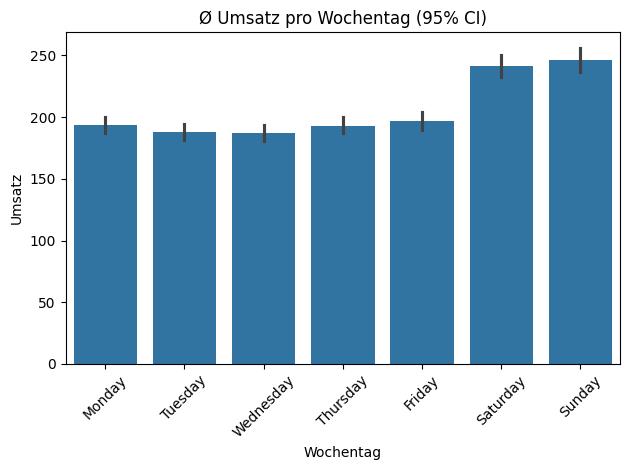

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

df_all['Wochentag'] = df_all['Datum'].dt.day_name()


# Durchschnittlicher Umsatz pro Wochentag
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(data=df_all, x='Wochentag', y='Umsatz', order=weekday_order, ci=95)
plt.title("Ø Umsatz pro Wochentag (95% CI)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


🌡️ 2. Temperatur über Zeit & Einfluss auf Umsatz 

Scatterplot evtl. nur semi-sinnvoll in diesem Fall.

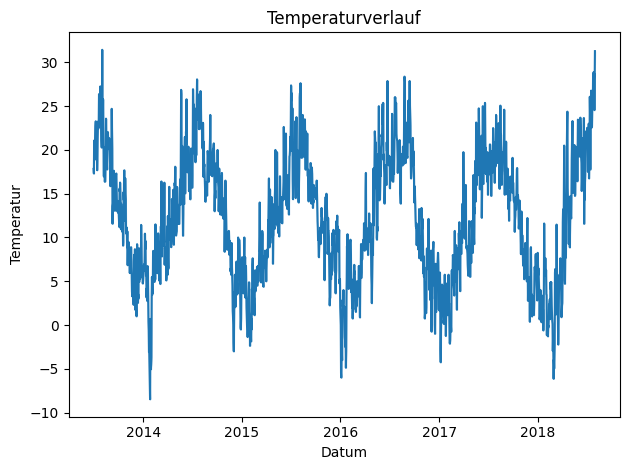

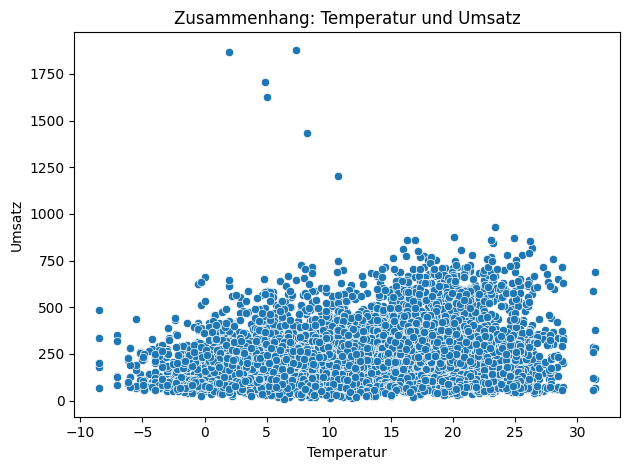

In [8]:
# Temperaturverlauf über Zeit
sns.lineplot(data=df_all, x='Datum', y='Temperatur')
plt.title("Temperaturverlauf")
plt.tight_layout()
plt.show()

# Zusammenhang Temperatur – Umsatz
sns.scatterplot(data=df_all, x='Temperatur', y='Umsatz')
plt.title("Zusammenhang: Temperatur und Umsatz")
plt.tight_layout()
plt.show()


🌧️ 3. Einfluss von Wetter & Wind

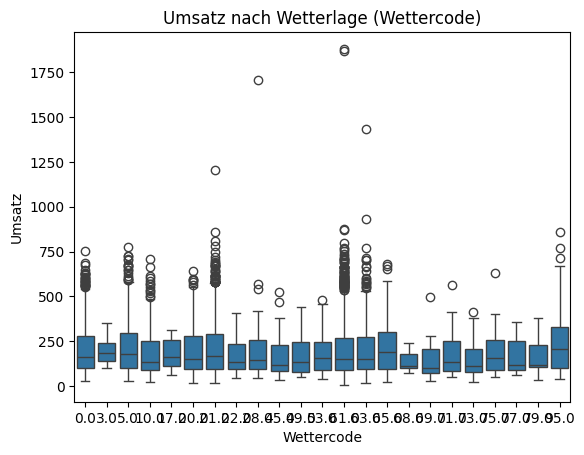

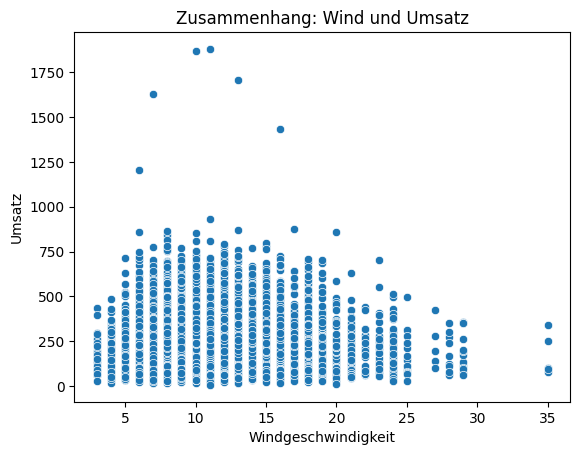

In [9]:
# Umsatz nach Wettercode
sns.boxplot(data=df_all, x='Wettercode', y='Umsatz')
plt.title("Umsatz nach Wetterlage (Wettercode)")
plt.show()

# Umsatz nach Windgeschwindigkeit
sns.scatterplot(data=df_all, x='Windgeschwindigkeit', y='Umsatz')
plt.title("Zusammenhang: Wind und Umsatz")
plt.show()


🎉 4. Warengruppenvergleich KiWo / Nicht KiWo

/tmp/ipykernel_6520/2403419999.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vergleich_sorted.index, y=vergleich_sorted['Differenz'], palette='coolwarm')


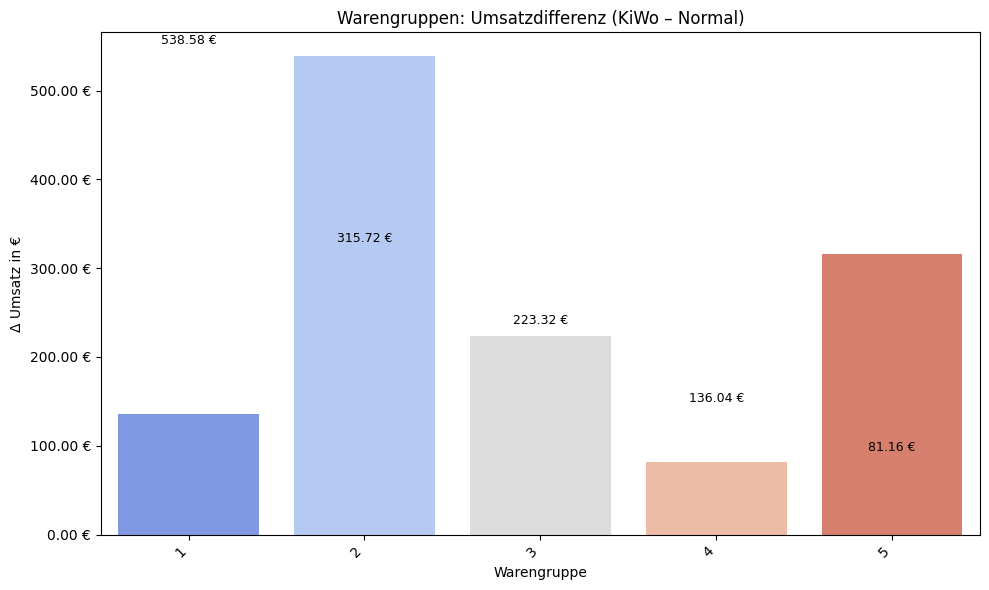

In [ ]:
# Aufteilen
df_kiwo = df_all[df_all['KielerWoche'] == True]
df_normal = df_all[df_all['KielerWoche'] == False]

# Gruppieren: durchschnittlicher Umsatz je Warengruppe
umsatz_kiwo = df_kiwo.groupby('Warengruppe')['Umsatz'].mean()
umsatz_normal = df_normal.groupby('Warengruppe')['Umsatz'].mean()

# Zusammenführen
vergleich = pd.DataFrame({
    'KiWo': umsatz_kiwo,
    'Normal': umsatz_normal
}).fillna(0)

# Differenz berechnen
vergleich['Differenz'] = vergleich['KiWo'] - vergleich['Normal']
vergleich['Verhältnis'] = vergleich['KiWo'] / vergleich['Normal'].replace(0, 1)  # avoid div by zero

# Sortieren nach größter positiver Differenz
vergleich_sorted = vergleich.sort_values('Differenz', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=vergleich_sorted.index,
    y=vergleich_sorted['Differenz'],
    order=vergleich_sorted.index,  # erzwingt exakte Reihenfolge
    palette='coolwarm'
)


# Achsenbeschriftung mit €
import matplotlib.ticker as ticker
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.2f} €"))

# Balkenbeschriftung
for i, val in enumerate(vergleich_sorted['Differenz']):
    plt.text(i, val + 10, f"{val:,.2f} €", ha='center', va='bottom', fontsize=9)

plt.title("Warengruppen: Umsatzdifferenz (KiWo – Normal)")
plt.ylabel("Δ Umsatz in €")
plt.xlabel("Warengruppe")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




### Umsatzanalyse nach Warengruppe: Kieler Woche vs. Normalzeit

Der obige Plot zeigt die Differenz des durchschnittlichen Tagesumsatzes je Warengruppe während der Kieler Woche im Vergleich zu regulären Tagen. Alle dargestellten Warengruppen weisen einen positiven Unterschied auf – sie verkaufen sich also während der KiWo besser. Besonders Warengruppe 2 und 5 scheinen stark von der KiWo zu profitieren.
